In [1]:
import csv
from matplotlib import pyplot as plt
import numpy as np
from scipy.misc import imread
import pickle
import cv2
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_context("poster")

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


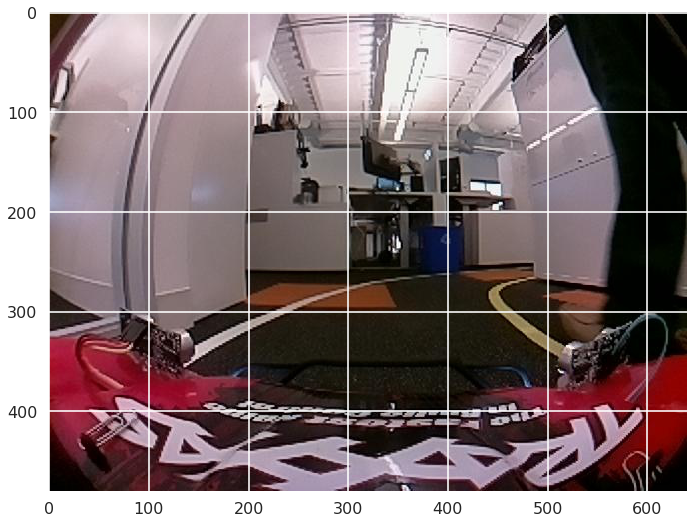

In [4]:
img = imread("data/office_3/0.jpg")
plt.imshow(img)


In [6]:
# this file is used to process the raw output of recording training data from the simulator
# and prepare it for uploading to the AWS GPU

folder_to_process = "data/office_3"
print("Processing ", folder_to_process)


def extract_data(folder):
    X = [] #images
    XX = [] #senor data (aka speed in this case)
    y = [] #actual steering angles (throttle in the future)


    with open('{}/_data.csv'.format(folder_to_process)) as f:
        reader = csv.reader(f)
        print(''.join(next(reader)))
        for line in reader:
            line = ''.join(line).split('|')
            img_file= "{}".format(int(line[0]))
            img = imread('{}/{}.jpg'.format(folder_to_process, img_file))
            
            
            X.append(img)
            #index 8 - throttle is -100 to 100
            #index 7 - rpm is 5000ish max
            XX.append([float(line[8])/100, float(line[8])/5000]) 
            y.append([float(line[5])/45]) # steering is -45 to 45

    return (np.array(X), np.array(XX), np.array(y))


X_train, XX_train, y_train = extract_data(folder_to_process)

print("--done--")

Processing  data/office_3
image_id|ACC|MAG|UFL|GYR|STR|UFR|RPM|THR|PRH|time
--done--


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


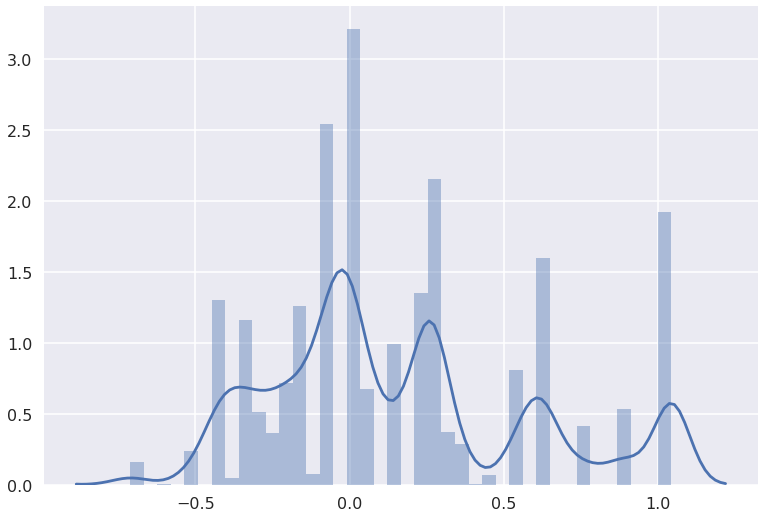

In [181]:
sns.distplot(y_train)

In [9]:
#bring in camera calibration matrix
# with open('../project_4/fisheye_f1p8_camera_calibration.pkl', 'rb') as f:
#     calibration = pickle.load(f)
# mtx = calibration["mtx"]
# ncmtx = calibration["camera_mtx"]
# dist = calibration["dist"]

def pipeline(image):
    #undistort it
#     undistort = cv2.undistort(image, mtx, dist, None, mtx)
#     output = undistort[200:361,:,:]
    output = image[200:361,:,:]
    return  cv2.resize(output, (0,0), fx=0.5, fy=0.5)  

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


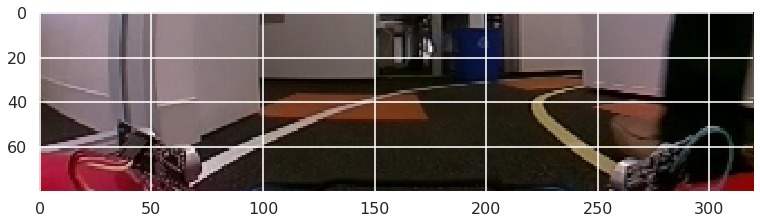

In [11]:
x = X_train[0]
plt.imshow(pipeline(x))

In [13]:
#reduce image to the road section and apply any transforms in the pipeline
X_train = np.array([pipeline(x) for x in X_train])

In [14]:
X_train.shape

(9601, 80, 320, 3)

In [15]:
# the following section was used to scrub through the video and find bad sections and remove them
current_frame = 0
scroll_rate = 5

Current Frame:  1245 Steering [ 0.62222222] Throttle [ 0.05   0.001]


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


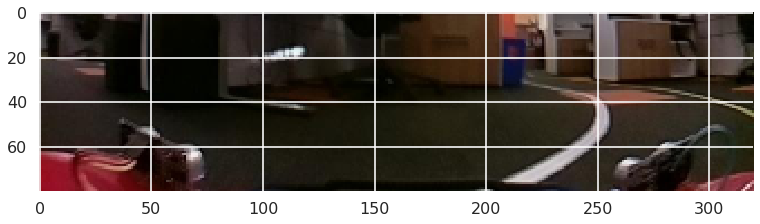

In [269]:
#scrub through thismanually for bad frames.... ouch time consuming
print("Current Frame: ", current_frame, "Steering", y_train[current_frame], "Throttle", XX_train[current_frame] )
plt.imshow(X_train[current_frame])
current_frame += scroll_rate



In [255]:
#drop bad frames
## bag 1
data_frames_to_drop = [(0,185), (7800, 7975)]


clean_indicies = np.ones(len(X_train))
for r in data_frames_to_drop:
    clean_indicies[r[0]:r[1]] = 0

In [256]:
X_cleaned = X_train[clean_indicies.astype(np.bool)]
XX_cleaned = XX_train[clean_indicies.astype(np.bool)]
y_cleaned = y_train[clean_indicies.astype(np.bool)]

print(X_cleaned.shape,XX_cleaned.shape, y_cleaned.shape)

data = {
    "images": X_train,
    "sensors": XX_train,
    "steering_throttle": y_train
}

(9241, 80, 320, 3) (9241, 2) (9241, 1)


In [634]:
with open('V79_office_run_2.pkl', 'wb') as f:
    pickle.dump(data, f)

In [180]:
y_train.shape

(9601, 1)

In [ ]:
y_train